# Hip Hop FEET Study
## Basis Health Tracker Data Preparation

The purpose of this notebook is to prepare the data collected by the Basis Health Trackers in order to run an analysis on the biometrics collected on the participants of the study.

## Basis Health Tracker "Activity"

Bases Health Tracker activities are defined a window of time in which the participant's physical activity is measured. There is a start time and end time associated with the activity, as well as a bunch of biometrics, such as average heart beats per minute, average number of steps taken, etc.

We want to be able to look at the biometrics of each participant and the study group as a whole.

# Reading the Data

The data are organized in sub-folders such that the each sub-folder contains readings from a particular device, and each file is a different data file. The [basis data export repo](https://github.com/cosmicBboy/basis-data-export) outputs three types of data files:

- activities: windows of time that contains aggregate biometrics.
- metrics: raw data that contains specific readings for an entire day's worth
- sleep: sleep data (we did not collect this data)

For the purposes of this notebook, we will only use the activities data.

In [164]:
import pandas as pd
import os
from IPython.display import display
from datetime import date
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
num_participants = 10
data_dir = '../data'
# for i in range(1, num_participants + 1):

def read_device_data(device_num, data_format):
    '''Reads activity or metrics data for a particular device
    
    Valid data_formats are 'activites' and 'metrics'.
    '''
    if data_format not in ['activities', 'metrics']:
        raise ValueError('{} is not a recognized data format. '
                         'Choose "activities" or "metrics"'.format(data_format))
    device_fp = 'hhph.breaker{}@gmail.com'.format(device_num)
    device_dir = os.path.join(data_dir, device_fp)
    device_data = [pd.read_csv(os.path.join(device_dir, f))
                  for f in os.listdir(device_dir)
                  if data_format in f]
    device_data = pd.concat([df for df in device_data if not df.empty])
    device_data['device_number'] = device_num
    return device_data

def read_all_device_data(num_participants, data_format):
    dfs = [read_device_data(i + 1, data_format) for i in range(num_participants)]
    return pd.concat(dfs).reset_index(drop=True)

In [67]:
def clean_metrics_data(metrics_df):
    '''Filters out invalid metrics rows
    
    Here we define invalid metrics rows as those rows that
    have null values in the 'gsr', 'skintemp', and 'airtemp'
    columns.
    
    This is becuase is seems like there are residual readings
    in the 'steps' and 'calories' columns, even if we know
    for a fact that a dance sessian was not happening.
    '''
    check_cols = ['gsr', 'skintemp', 'airtemp']
    idx1 = metrics_df[metrics_df[check_cols].notnull().all(axis=1)].index.tolist()
    idx2 = metrics_df[(metrics_df['steps'] > 0) | 
                      (metrics_df['calories'] > 1.0)].index.tolist()
    idx = list(set(idx1 + idx2))
    metrics_df = metrics_df.iloc[idx]
    return metrics_df.reset_index(drop=True)

def add_time_data(df, ts_col):
    '''Adds date and time column
    '''
    ts = pd.to_datetime(df[ts_col])
    df.loc[:, 'timestamp'] = ts
    df.insert(0, 'date', ts.apply(lambda x: x.date()))
    df.insert(1, 'time', ts.apply(lambda x: x.time()))
    return df

metrics_df = clean_metrics_data(read_all_device_data(10, 'metrics'))
metrics_df = add_time_data(metrics_df, 'timestamp')
metrics_df.head()

,date,time,timestamp,heartrate,steps,calories,gsr,skintemp,airtemp,device_number
0,2015-01-23,16:23:00,2015-01-23 16:23:00,NaN,0.0,0.8,0.000463,74.5250,72.5000,10
1,2015-01-23,16:24:00,2015-01-23 16:24:00,NaN,81.0,3.0,0.584000,78.3125,72.6650,10
2,2015-01-23,16:25:00,2015-01-23 16:25:00,NaN,58.0,3.3,6.460000,80.4500,73.5650,10
3,2015-01-23,16:26:00,2015-01-23 16:26:00,NaN,6.0,1.6,16.200000,81.6500,74.5475,10
4,2015-01-23,16:27:00,2015-01-23 16:27:00,NaN,11.0,1.9,21.600000,82.4750,75.7325,10


In [68]:
activity_df = read_all_device_data(10, 'activities')
activity_df = add_time_data(activity_df, 'start time')
activity_df.head()

,date,time,start time,start time ISO,start time timezone,start time offset,end time,end time ISO,end time timezone,end time offset,...,calories,minutes,heart rate avg,heart rate min,heart rate max,state,version,id,device_number,timestamp
0,2014-11-14,16:20:09,2014-11-14 16:20:09,2014-11-14T21:20:09Z,America/Los_Angeles,-480,2014-11-14 16:26:42,2014-11-14T21:26:42Z,America/Los_Angeles,-480,...,18.700001,6.550000,NaN,NaN,NaN,complete,1,walk__2014-11-14T212009,1,2014-11-14 16:20:09
1,2015-01-23,16:54:58,2015-01-23 16:54:58,2015-01-23T21:54:58Z,America/New_York,-300,2015-01-23 16:59:52,2015-01-23T21:59:52Z,America/New_York,-300,...,20.000000,4.900000,NaN,NaN,NaN,complete,1,walk__2015-01-23T215458,1,2015-01-23 16:54:58
2,2015-02-06,16:54:37,2015-02-06 16:54:37,2015-02-06T21:54:37Z,America/New_York,-300,2015-02-06 16:54:57,2015-02-06T21:54:57Z,America/New_York,-300,...,5.700000,0.333333,NaN,NaN,NaN,complete,1,run__2015-02-06T215437,1,2015-02-06 16:54:37
3,2015-02-06,16:54:57,2015-02-06 16:54:57,2015-02-06T21:54:57Z,America/New_York,-300,2015-02-06 16:59:00,2015-02-06T21:59:00Z,America/New_York,-300,...,20.299999,4.050000,NaN,NaN,NaN,complete,1,walk__2015-02-06T215457,1,2015-02-06 16:54:57
4,2015-02-13,16:54:49,2015-02-13 16:54:49,2015-02-13T21:54:49Z,America/Los_Angeles,-480,2015-02-13 16:59:37,2015-02-13T21:59:37Z,America/Los_Angeles,-480,...,24.100000,4.800000,NaN,NaN,NaN,complete,1,walk__2015-02-13T215449,2,2015-02-13 16:54:49


## Is the `activities` and `metrics` data consistent with each other?

We want to check whether the aggregate metrics in the `activities` data matches the readings in the `metrics` data? For example, can we find a case where there are no aggregate readings in the `activities` dataset but there are in fact some readings in the `metrics` data?

In [69]:
# look at data fro 2014-11-14, device 1
d = date(2015, 2, 27)
device_num = 1
d1 = metrics_df[(metrics_df['date'] == d) & 
                (metrics_df['device_number'] == device_num)]
print "Mean heartrate for device {} in {}: {:0.2f}".format(device_num, d, d1['heartrate'].mean())

Mean heartrate for device 1 in 2015-02-27: 121.09


In [70]:
activity_df[(activity_df['date'] == d) &
            (activity_df['device_number'] == device_num)]

,date,time,start time,start time ISO,start time timezone,start time offset,end time,end time ISO,end time timezone,end time offset,...,calories,minutes,heart rate avg,heart rate min,heart rate max,state,version,id,device_number,timestamp


## Findings

There seems to be a discrepency in the activity data and the metrics data. For example, in device `1` in `2-27-2015`, it looks like the device captured some metrics data, but the activity dataset did not record any aggregate metrics. This means we'll have to recompute these aggregates using the raw metrics.

# Plotting the Raw Data

Before going further in our analysis, we want to visualize the raw data that we can get a better sence of how valid they are. We are going to try to recreate the charts that are given to Basis Health App users on their [web application](https://app.mybasis.com).

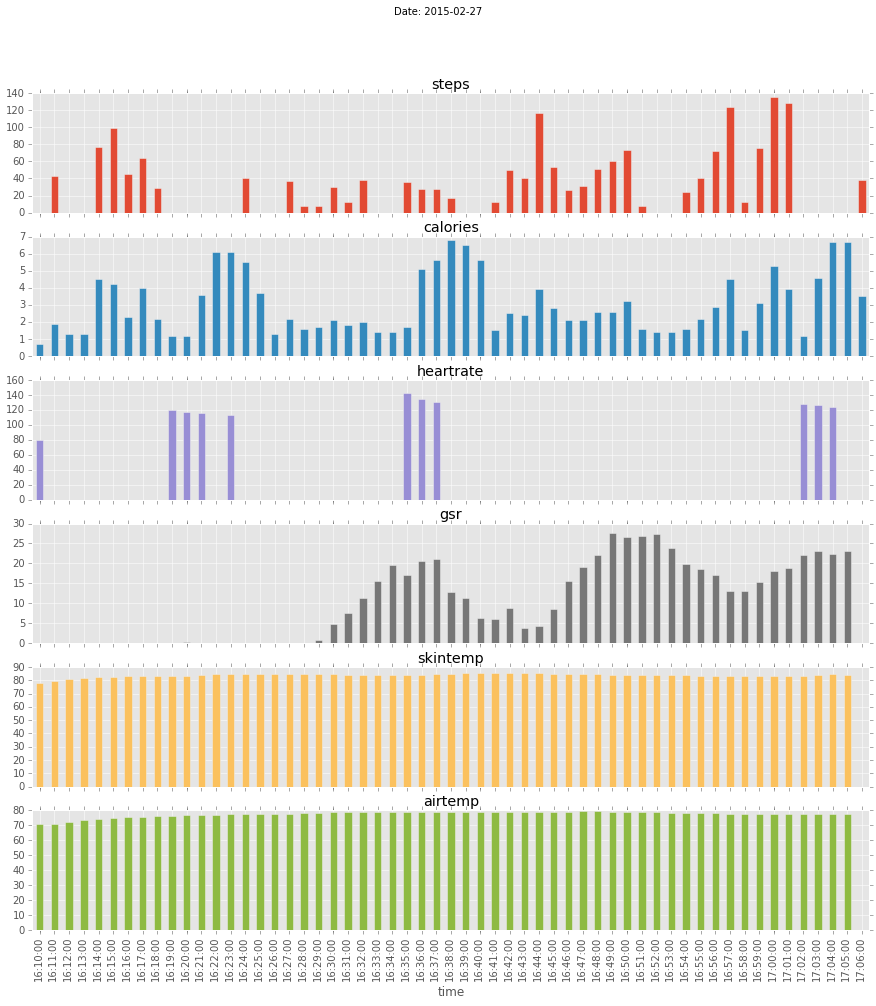

In [137]:
# Plotting steps and calories for one day and one device
d = date(2015, 2, 27)
device_num = 1
plot_df = metrics_df[(metrics_df['date'] == d) &
                     (metrics_df['device_number'] == device_num)]
n = 2
plot_cols_1 = ['steps', 'calories', 'heartrate', 'gsr', 'skintemp', 'airtemp']
ax1 = plot_df.plot(kind='bar', x='time', y=plot_cols_1, 
                   figsize=(15,15), subplots=True, sharex=True,
                   legend=False, title="Date: {}".format(d))

The plots above replicate the results in the Basis web application. Let's compute the aggregat measures for this one activity to double check.

In [182]:
agg_metrics = pd.concat([plot_df.mean().to_frame('mean'),
                         plot_df.sum().to_frame('sum')], axis=1)
display(agg_metrics)

,mean,sum
heartrate,121.090909,1332.00000
steps,31.842105,1815.00000
calories,3.059649,174.40000
gsr,10.619756,594.70631
skintemp,83.801387,4692.87768
airtemp,77.655446,4348.70500
device_number,1.000000,57.00000


It looks like the mean and total values for each metric are reasonably close to the measures shown below. The mean value for steps taken that we've calculated above is slightly higher than that shown in the web application, but it's no bigger than an order of magnitude, which is acceptable.

<img src="basis_device1_2015-02-27.png">

# Recomputing aggregate metrics

We want to group by date and compute the mean values for the following metrics:

`heartrate`, `steps`, `calories`, `gsr` (galvanic skin response), `skintemp`, `airtemp`.

In [287]:
date_device_groups = metrics_df.groupby(['device_number', 'date'])
agg_cols = ['steps', 'calories', 'heartrate', 'gsr', 'skintemp', 'airtemp']
agg_metrics = date_device_groups[agg_cols].agg([np.mean, sum]).reset_index()
agg_metrics.columns = ['_'.join(col).strip().strip('_')
                       for col in agg_metrics.columns.values]

# compute aggregate time per session per device
agg_time = date_device_groups['timestamp'].agg([min, max]).reset_index()
agg_time = agg_time['max'] - agg_time['min']

agg_metrics.insert(2, 'total_minutes', 
                   agg_time.apply(lambda x: x.seconds / 60.0))

# save data to csv file
agg_metrics.to_csv('../data/aggregate_metrics.csv', index=False)
agg_metrics.head()

,device_number,date,total_minutes,steps_mean,steps_sum,calories_mean,calories_sum,heartrate_mean,heartrate_sum,gsr_mean,gsr_sum,skintemp_mean,skintemp_sum,airtemp_mean,airtemp_sum
0,1,2014-11-14,51.0,23.340909,1027.0,3.325000,146.3,128.571429,900.0,13.046090,574.027956,83.417516,3670.37071,77.345170,3403.1875
1,1,2015-01-16,37.0,26.789474,1018.0,1.897368,72.1,101.666667,610.0,4.785752,181.858559,82.214518,3124.15170,76.961908,2924.5525
2,1,2015-01-23,37.0,28.315789,1076.0,2.052632,78.0,98.400000,492.0,1.161317,44.130050,83.552632,3175.00000,78.959671,3000.4675
3,1,2015-02-06,41.0,32.095238,1348.0,2.000000,84.0,98.166667,589.0,10.802224,442.891191,84.606098,3468.85000,78.857622,3233.1625
4,1,2015-02-13,40.0,17.542857,614.0,1.591429,55.7,79.000000,237.0,1.178148,38.878890,81.027375,2673.90339,76.262045,2516.6475


### Plotting mean number of steps for each session, per device

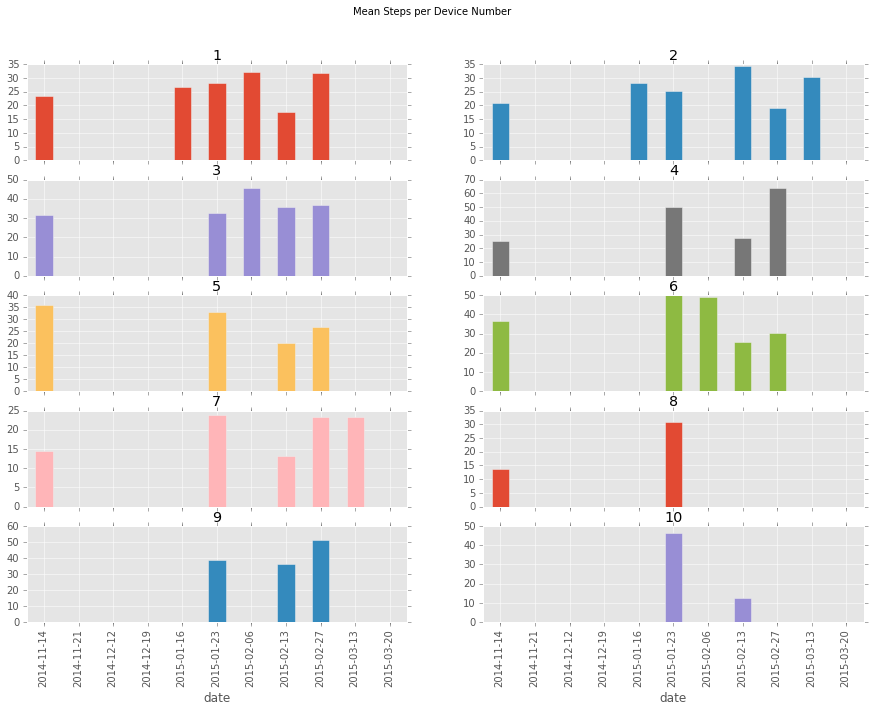

In [285]:
plot_df = agg_metrics.pivot(
    index='date', columns='device_number', values='steps_mean')
# insert null index for missing data days
plot_df.loc[date(2014, 11, 21), :] = np.nan
plot_df.loc[date(2014, 12, 12), :] = np.nan
plot_df.loc[date(2014, 12, 19), :] = np.nan
plot_df.loc[date(2015, 3, 20), :] = np.nan
plot_df.sort_index(inplace=True)
plot_df.plot(kind='bar', subplots=True, figsize=(15,10), 
             layout=(5,2), legend=False, title='Mean Steps per Device Number');

### Plotting mean number of calories for each session, per device

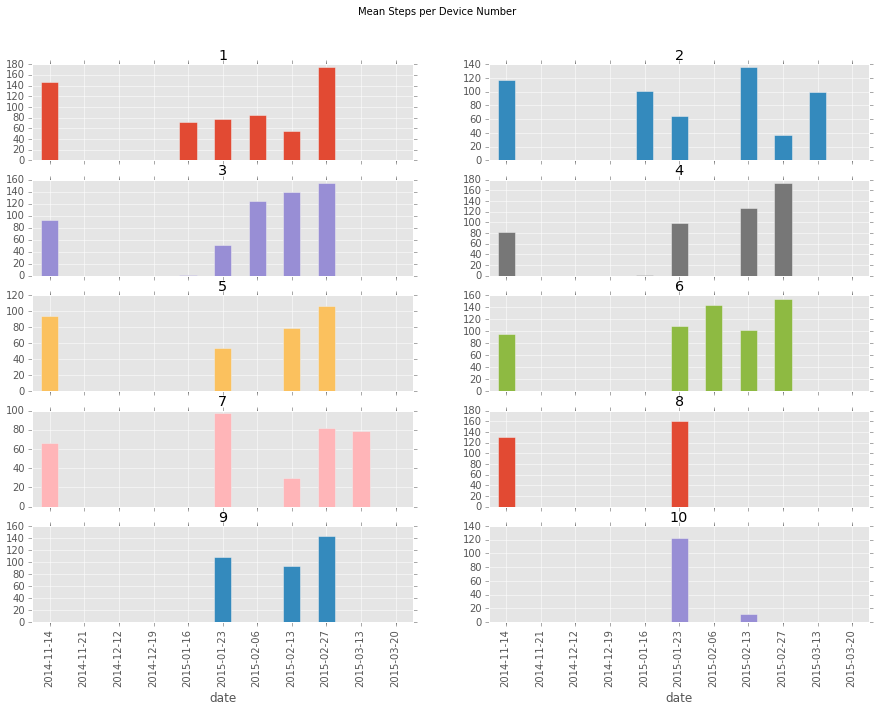

In [286]:
plot_df = agg_metrics.pivot(
    index='date', columns='device_number', values='calories_sum')
plot_df.loc[date(2014, 11, 21), :] = np.nan
plot_df.loc[date(2014, 12, 12), :] = np.nan
plot_df.loc[date(2014, 12, 19), :] = np.nan
plot_df.loc[date(2015, 3, 20), :] = np.nan
plot_df.sort_index(inplace=True)
plot_df.plot(kind='bar', subplots=True, figsize=(15,10), 
             layout=(5,2), legend=False, title='Mean Steps per Device Number');